# Pracownicze Plany Kapitałowe 
## (Employee Capital Plans)
One of the solutions that have been introduced in recent years in European countries and in the world are employee retirement plans, which consist of saving for retirement purposes by systematically transferring part of the remuneration by the employee and his employer. On January 1, 2019, the Act on Employee Capital Plans (Pracownicze Plany Kapitałowe) entered into force (hereinafter also as PPK), i.e. the Polish version of this solution.

The purpose of this analysis is to find the answer to the question to what extent this solution will help to secure a pensioner's standard of living after the end of his professional activity and whether from the perspective of today's employee - it is profitable to enter the program.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from dateutil.relativedelta import relativedelta
pd.set_option('display.float_format', lambda x: '%.5f' % x)

The value of the received benefit directly depends on many factors - the most important are: 
- the time of transferring capital to funds, 
- the value of transferred capital and, due to the fact that PPK invests the entrusted funds on the capital market 
- rates of return on invested capital.

In [2]:
n = 40                                #number of years 
initial_capital = 4850
yearly_salary_growth = 0.04
employee_contribution = 0.02          #min 2%, max 4%
employer_contribution = 0.015         #min 1.5%, max 4%
contribution_rate = employer_contribution + employee_contribution
management_cost = (1+0.005)**(1/12)-1 
reference_rate = 2.5

 - Gross remuneration (salary) - the basis for calculating the premium - in the first year amounts to PLN 4,850 (an amount similar to the average remuneration for work in the enterprise sector in 2018).
 - Salary increases by 4% each year - in 2008-2018 the annual nominal increase in the average monthly salary in the enterprise sector was 4.33%.
 - The employee and employer contributions have been set at the lowest possible level.

The next steps in this analysis will be presented in steps. First, a table will be prepared presenting the employee's salary, monthly contributions and a "gift" from the state.

In [3]:
contributions = pd.DataFrame({"salary": [np.nan]*n*12})
contributions.index = pd.date_range(start='2020-01-01', freq='MS', periods=n*12)

#creating a monthly salary that will be increased every year (in January)
contributions.iloc[0] = initial_capital
for i in range(1, len(contributions.index)):
    if contributions.index[i].month != 1:
        contributions.iloc[i] = contributions.iloc[i-1]
    else:
        contributions.iloc[i] = round(contributions.iloc[i-1] * (1 + yearly_salary_growth), 2)

#creating a monthly contribution, separately as part financed by the employee and employer
contributions['employee_contr'] = round(contributions['salary'] * employee_contribution, 2)
contributions['employer_contr'] = round(contributions['salary'] * employer_contribution, 2)

#contribution financed by state amounts to 240 every March, 
#but the first year of participation in the program, the participant gets PLN 250 in April
contributions['state_contr'] = np.nan
contributions['state_contr'].iloc[4] = 250
for index, row in contributions[5:].iterrows():
    if index.month == 3:
        contributions['state_contr'].loc[index] = 240
contributions['state_contr'].fillna(0, inplace=True)
        
contributions['monthly'] = contributions[
    ['employee_contr', 'employer_contr', 'state_contr']].sum(axis=1)

In [4]:
contributions.head()

,salary,employee_contr,employer_contr,state_contr,monthly
2020-01-01,4850.00000,97.00000,72.75000,0.00000,169.75000
2020-02-01,4850.00000,97.00000,72.75000,0.00000,169.75000
2020-03-01,4850.00000,97.00000,72.75000,0.00000,169.75000
2020-04-01,4850.00000,97.00000,72.75000,0.00000,169.75000
2020-05-01,4850.00000,97.00000,72.75000,250.00000,419.75000


The state contribution is PLN 240 once a year in March. In the first year, however, it is PLN 250 and is received by employee in April. The level of contributions is constant throughout the investment period, and the employee's salary increases with each new year.

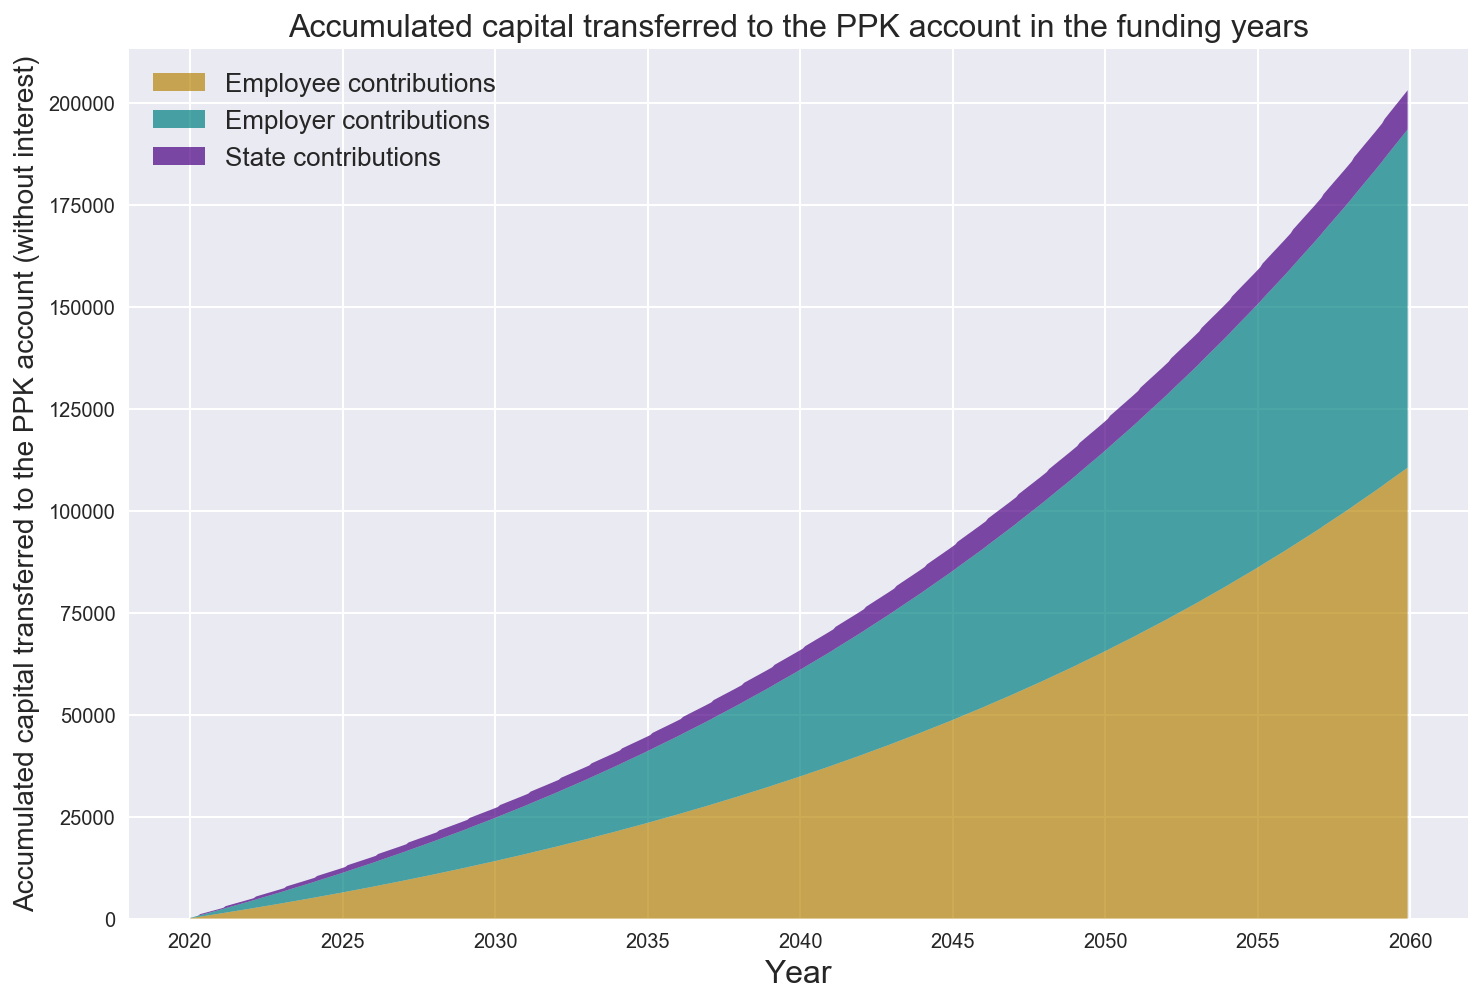

In [5]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
stacked = np.vstack([contributions.iloc[:,1].cumsum(),
                     contributions.iloc[:,2].cumsum(),
                     contributions.iloc[:,3].cumsum()])
plt.stackplot(contributions.iloc[:,1:-1].index, stacked, alpha=.7,
              labels=['Employee contributions', 'Employer contributions', 'State contributions'],
              colors=['darkgoldenrod', 'teal', 'indigo'])
plt.title('Accumulated capital transferred to the PPK account in the funding years',
          fontdict={'fontsize':16})
plt.xlabel('Year', fontdict={'fontsize':16})
plt.ylabel('Accumulated capital transferred to the PPK account (without interest)',
           fontdict={'fontsize':14})
plt.legend(loc='upper left', prop={'size':13})
plt.show()

In [6]:
total = contributions.iloc[:,1:-1].cumsum()[-1:].sum(axis=1)[0]
print('Accumulated capital based on employee contributions is {0:.2%}.'.format(
    contributions['employee_contr'].cumsum().iloc[-1]/total))
print('Accumulated capital based on employer contributions is {0:.2%}.'.format(
    contributions['employer_contr'].cumsum().iloc[-1]/total))
print('Accumulated capital based on state contributions is {0:.2%}.'.format(
    contributions['state_contr'].cumsum().iloc[-1]/total))

Accumulated capital based on employee contributions is 54.44%.
Accumulated capital based on employer contributions is 40.83%.
Accumulated capital based on state contributions is 4.73%.


Excluding the reinvestment of the transferred capital, it is possible to show on the chart which portion of the accumulated capital corresponds to which part of the contribution. The part donated by the state, despite being loudly advertised by the state itself, is responsible for a very small part of the accumulated capital. It should be noted, however, that the state contribution together with the employer's contribution is almost the same as the contribution of the employee himself.

Below, the same code calculating contributions is written in the form of single function so that it can be used repeatedly in the further part of the analysis.

In [7]:
def get_contributions(n, contribution_rate):
    contributions = pd.DataFrame({"salary": [np.nan]*n*12})
    contributions.index = pd.date_range(start='2020-01-01', freq='MS', periods=n*12)
    contributions.iloc[0] = initial_capital
    for i in range(1, len(contributions.index)):
        if contributions.index[i].month != 1:
            contributions.iloc[i] = contributions.iloc[i-1]
        else:
            contributions.iloc[i] = round(contributions.iloc[i-1] * (1 + yearly_salary_growth), 2)
    contributions['contribution'] = round(contributions['salary'] * contribution_rate, 2)
    contributions['state_contr'] = np.nan
    contributions['state_contr'].iloc[4] = 250
    for index, row in contributions[5:].iterrows():
        if index.month == 3:
            contributions['state_contr'].loc[index] = 240
    contributions['state_contr'].fillna(0, inplace=True)
    contributions['monthly'] = contributions[
      ['contribution', 'state_contr']].sum(axis=1)
    return contributions

contributions = get_contributions(n, contribution_rate)

PPK provides for the possibility of investing funds in so called lifecycle investment fund, which are characterized by a variable proportion of equity and debt in order to limit investment risk. In the initial years of investment, the funds are focused on increasing the value of capital, while in recent years on maintaining stability and security. The closer to the year in which retirement starts, the greater part is invested in secure debt instruments.

The function below calculates the month in which the collected capital will be transferred to a safer fund focusing mainly on debt securities.

In [8]:
def get_shares(n):
    share = pd.DataFrame(data={'debt_share':1, 'equity_share':1}, 
                    index=pd.date_range(start='2020-01-01', freq='MS', periods=n*12))
    choices = [.3, .45, .65, .8] 
    for index, row in share.iterrows():
        remaining_time = relativedelta(share.index[-1], index).years
        cond = [remaining_time >= 20,
          10 <= remaining_time < 20,
          5 <= remaining_time < 10,
          1 <= remaining_time < 5]
        share.loc[index,'debt_share'] = np.select(cond, choices, 0.9)
    share['equity_share'] = 1 - share['debt_share']
    return share

share = get_shares(n)
share

,debt_share,equity_share
2020-01-01,0.30000,0.70000
2020-02-01,0.30000,0.70000
2020-03-01,0.30000,0.70000
2020-04-01,0.30000,0.70000
2020-05-01,0.30000,0.70000
...,...,...
2059-08-01,0.90000,0.10000
2059-09-01,0.90000,0.10000
2059-10-01,0.90000,0.10000
2059-11-01,0.90000,0.10000


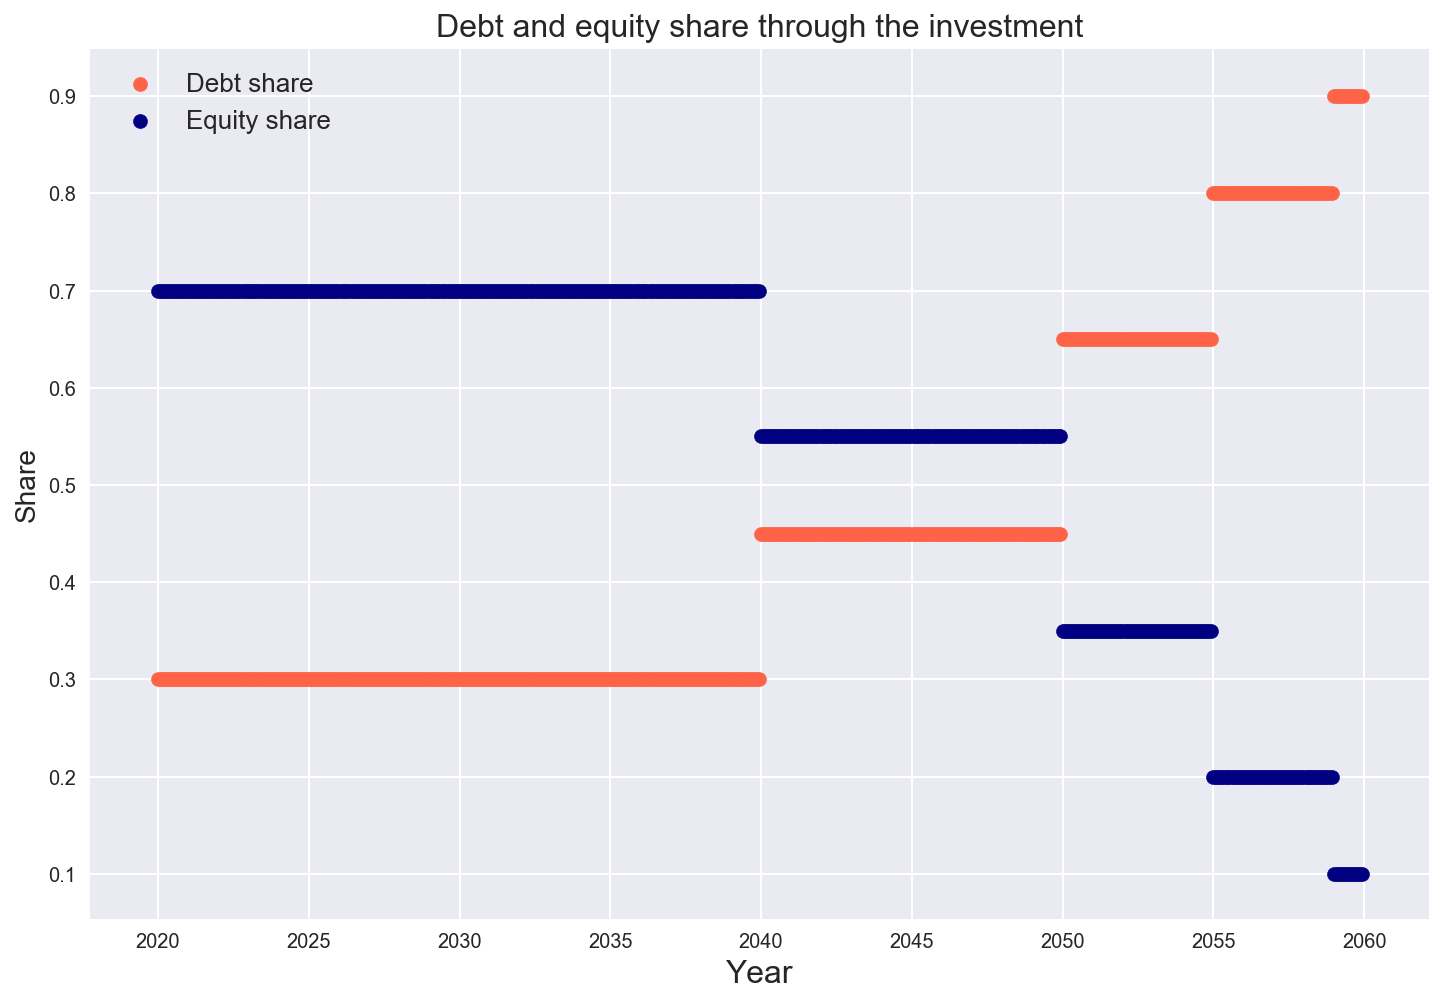

In [9]:
plt.figure(figsize=(12,8))
plt.scatter(y=share['debt_share'], x=share.index, color='tomato')
plt.scatter(y=share['equity_share'], x=share.index, color='navy')
plt.title('Debt and equity share through the investment', fontdict={'fontsize':16})
plt.xlabel('Year', fontdict={'fontsize':16})
plt.ylabel('Share',fontdict={'fontsize':14})
plt.legend(loc='best', prop={'size':13}, labels=['Debt share', 'Equity share'])
plt.show()

The above chart shows that (assuming PPK investments until 2060) the assets are shuffled between funds 4 times, i.e. in 2040, 2050, 2055 and 2059. For 40 years of investment, as much as half of this period was mainly focused on investments in shares and other equity instruments, which allows for an increase in value in the first years of investment.

However, if participation in PPK lasted less than 40 years, e.g. only 10, then the first division of assets between different securities will start from the debt portion significantly exceeding the share portion.

Modelling potential replacement rates has one huge disadvantage - it is not possible to predict with perfect accuracy how the financial market will behave in the future, and thus what return rates will be provided by individual instruments in future years. Bearing in mind that the PPK Act requires investment in the share portion of at least 4 different types of equity instruments, the WIG20, mWIG40, sWIG80 and FTSE250 indices have been selected for the model. On the basis of these indices artificial returns will be calculated and applied.

In [10]:
org_returns = pd.concat([
    pd.read_csv('wig20.csv', usecols=['Zamkniecie']),
    pd.read_csv('mwig40.csv', usecols=['Zamkniecie']),
    pd.read_csv('swig80.csv', usecols=['Zamkniecie']),
    pd.read_csv('ftse250.csv', usecols=['Zamkniecie'])], axis=1)

org_returns.columns = ['WIG20', 'mWIG40', 'sWIG80', 'FTSE250']
org_returns = org_returns.pct_change(1).dropna()

org_returns.head()

,WIG20,mWIG40,sWIG80,FTSE250
1,0.22606,-0.07305,0.22817,0.04371
2,-0.02835,0.10530,0.03432,0.00370
3,-0.10226,-0.05434,0.03269,-0.04332
4,-0.01376,-0.02811,0.03309,0.00536
5,-0.00844,0.01643,0.01326,0.05992


Above is the table with the original rates of return on indices for years 2000-2020. Based on them, by calculating  mean and standard deviation of each index, a function was created that will choose from the normal distribution artificial returns for next years. 

As for the debt share: it will be characterized by two parts - bonds with a rate of 2.8% per annum and "other" debt securities with a rate of 3.5% per annum.

In [11]:
def get_returns(n):
    returns = pd.concat([
        pd.Series(np.random.normal(org_returns['WIG20'].mean(), org_returns['WIG20'].std(), n*12)), 
        pd.Series(np.random.normal(org_returns['mWIG40'].mean(), org_returns['mWIG40'].std(), n*12)),
        pd.Series(np.random.normal(org_returns['sWIG80'].mean(), org_returns['sWIG80'].std(), n*12)),
        pd.Series(np.random.normal(org_returns['FTSE250'].mean(), org_returns['FTSE250'].std(), n*12))
                  ], axis=1)

    returns.columns = ['WIG20', 'mWIG40', 'sWIG80', 'FTSE250']
    returns.index = pd.date_range(start='2020-01-01', freq='MS', periods=n*12)

    returns['bonds'] = (1+0.028)**(1/12)-1
    returns['other_debt'] = (1+0.035)**(1/12)-1
    
    return returns

In [12]:
np.random.seed(20)
returns = get_returns(n)
returns.head()

,WIG20,mWIG40,sWIG80,FTSE250,bonds,other_debt
2020-01-01,0.06034,0.12128,0.01867,0.03750,0.00230,0.00287
2020-02-01,0.01528,0.06414,-0.14553,-0.01361,0.00230,0.00287
2020-03-01,0.02587,-0.01898,-0.03102,-0.00686,0.00230,0.00287
2020-04-01,-0.15100,-0.03683,0.04334,0.02273,0.00230,0.00287
2020-05-01,-0.06859,-0.05862,0.15684,0.03039,0.00230,0.00287


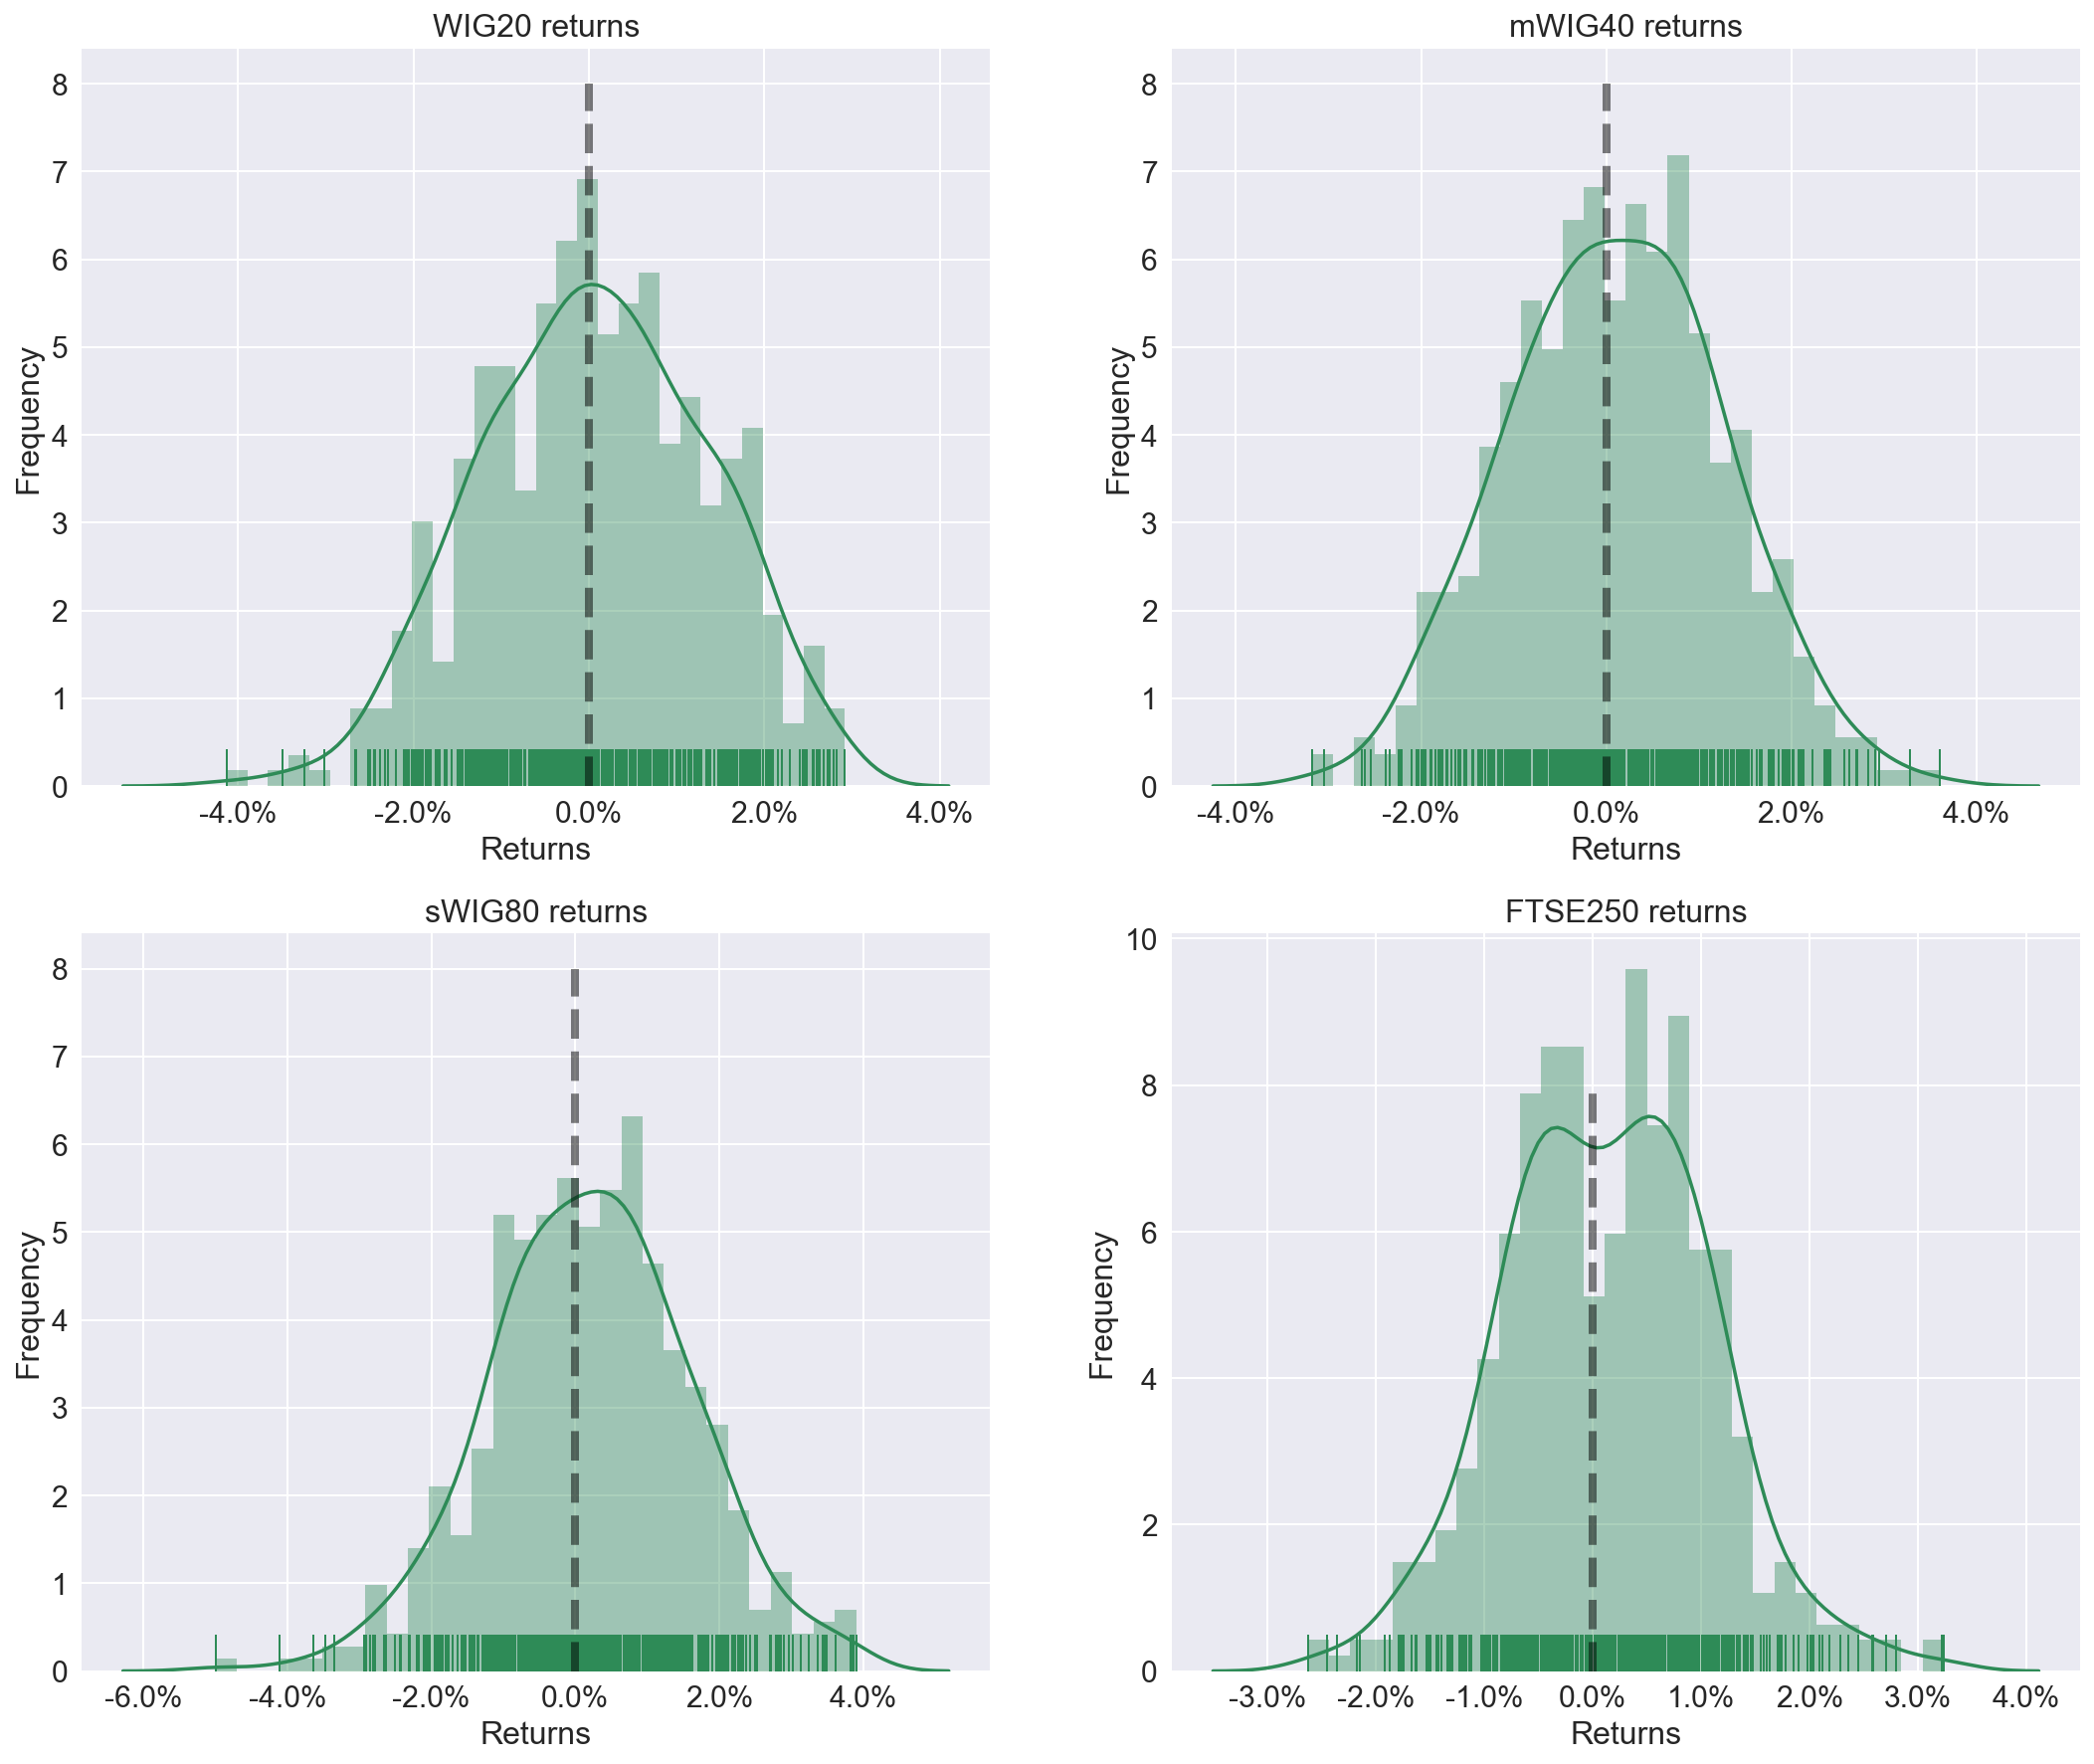

In [13]:
subplot = 221
plt.figure(figsize=(18,15))

for column_name, column in returns.iloc[:,:4].iteritems():    
    plt.subplot(subplot)
    sns.distplot(column, bins=30, color='seagreen', rug=True)
    plt.title('{} returns'.format(column_name), fontdict={'fontsize':16})
    plt.ylabel('Frequency', fontdict={'fontsize':16})
    plt.xlabel('Returns', fontdict={'fontsize':16})
    plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(xmax=5))
    plt.tick_params(labelsize=15)
    plt.plot([0, 0], [0, 8], 'k--', lw=4, alpha=0.5)
    subplot += 1

The distribution of generated rates of return based on individual indexes is presented above. As can be seen, their mean is close to a 0% return, but the standard deviation varies depending on the index.

During the PPK participation, the investment fund company collects remuneration for its investment services and the diversification of invested capital. In the case of PPK, two types of fees are charged:
- a fixed management fee charged monthly;
- a success fee, payable only if the fund achieves the required rate of return, charged once a year

The function below calculates whether the fund is entitled to a success fee in a given year.

In [14]:
def get_costs(n):
    costs = pd.DataFrame(data={'WIG20':1, 'mWIG40':1, 'sWIG80':1, 'FTSE250':1,
                              'bonds':1, 'other_debt':1}, 
                              index=pd.date_range(start='2020-01-01', freq='MS', periods=n*12))

    for column_name, column in costs.iteritems():
        value = 1
        for index, row in costs[1:].iterrows():
            value = value * (returns[column_name].loc[index] + 1)
            costs.loc[index, column_name] = value

    for index, row in costs.iterrows():
        costs.loc[index, 'cumulative'] = (
            row['WIG20'] * 0.45 + 
            row['mWIG40'] * 0.2 + 
            row['sWIG80'] * 0.1 + 
            row['FTSE250'] * 0.25) * share['equity_share'].loc[index] + (
            row['bonds'] * 0.8 + 
            row['other_debt'] * 0.2) * share['debt_share'].loc[index]

        #reference rate
        remaining_time = relativedelta(contributions.index[-1], index).years
        cond = [remaining_time >= 20,
            10 <= remaining_time < 20,
            5 <= remaining_time < 10,
            1 <= remaining_time < 5]
        choices = [reference_rate+2.5, reference_rate+1.5, reference_rate+1, reference_rate+.5]
        costs.loc[index, 'reference_rate'] = np.select(cond, choices, reference_rate)

        #success fee
        if (costs['cumulative'].pct_change(12).loc[index]*100 > costs.loc[index, 'reference_rate'] 
            and index.month == 1): 
            costs.loc[index, 'success_fee'] = True 
        else: 
            costs.loc[index, 'success_fee'] = False   
    return costs

costs = get_costs(n)
costs.head()

,WIG20,mWIG40,sWIG80,FTSE250,bonds,other_debt,cumulative,reference_rate,success_fee
2020-01-01,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,5.00000,False
2020-02-01,1.01528,1.06414,0.85447,0.98639,1.00230,1.00287,1.00195,5.00000,False
2020-03-01,1.04155,1.04395,0.82797,0.97962,1.00461,1.00575,1.00508,5.00000,False
2020-04-01,0.88427,1.00549,0.86386,1.00189,1.00693,1.00864,0.95730,5.00000,False
2020-05-01,0.82362,0.94656,0.99934,1.03234,1.00925,1.01153,0.94548,5.00000,False


A success fee is due only if the cumulative rate of return on all parts exceeds the reference rate (which is determined by the Minister of Finance and decreases as you approach retirement day).

Thus, the above function calculates the rate of return in relation to the first month of investment (for each part). Then the total rate of return is calculated (cumulative), covering all possible investments, after multiplication by appropriate weights.

In [15]:
costs['success_fee'].sum()

18

With generated rates of return, success fee is due to the investment fund company 18 times during 40 years of investment.

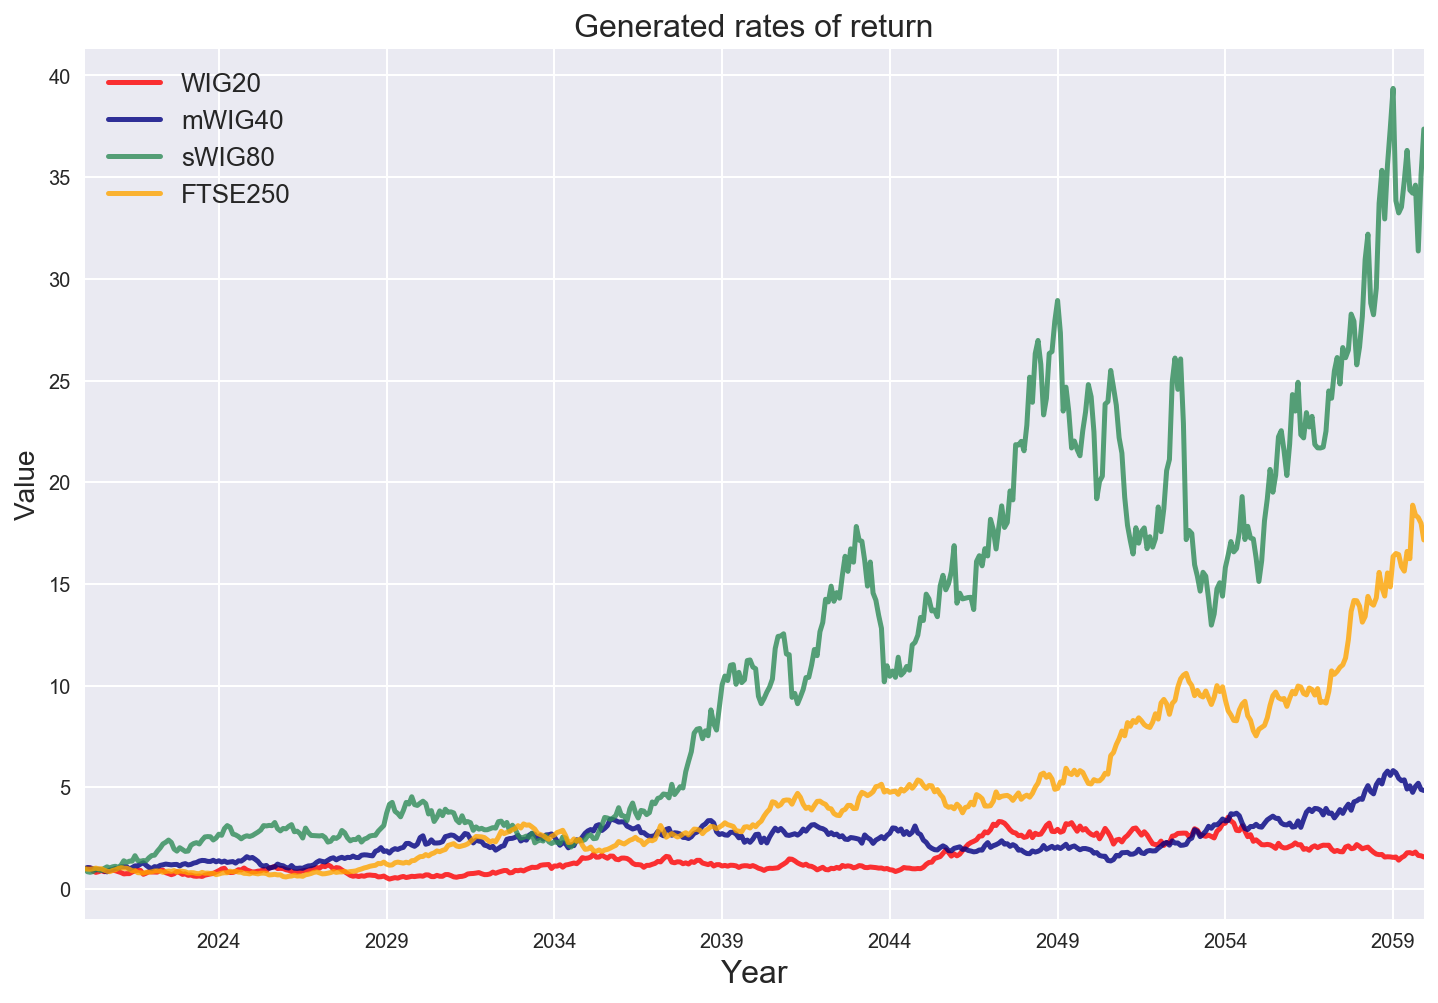

In [16]:
costs[['WIG20', 'mWIG40', 'sWIG80', 'FTSE250']].plot(
    figsize=(12,8), lw=2.5, alpha=.8, color=['red', 'navy', 'seagreen', 'orange'])
plt.title('Generated rates of return', fontdict={'fontsize':16})
plt.xlabel('Year', fontdict={'fontsize':16})
plt.ylabel('Value',fontdict={'fontsize':14})
plt.legend(loc='best', prop={'size':13})
plt.show()

The above chart presents the generated rates of return (without proper weighing). As can be seen above, the investment in sWIG80 shares is the most successful of them all - more than 35 times the initial value. In contrast, WIG20 shares remained at approximately the same level for 40 years. 

Although the chart above looks like the portfolio has a very high cumulative rate of return, in the PPK investment portfolio sWIG80-based-equities have a very small share. A much larger part, regardless of the investment fund company managing the fund, is dedicated to the companies included in WIG20.

Next, the main part of the model will occur: multiplying the capital raised each month by the rates of return assigned to that month, mixing the capital between the appropriate funds when it is required and reducing the amount collected by fixed and variable fees.

In [17]:
def get_inv(n):
    inv = pd.DataFrame(columns = ['WIG20', 'mWIG40', 'sWIG80', 'FTSE250', 'bonds', 'other_debt'],
        index=pd.date_range(start='2020-01-01', freq='MS', periods=n*12))

    values = [0 for x in range(6)]
    shares = ['equity_share' if x < 4 else 'debt_share' for x in range(6)]
    ratios = [.45, .2, .1, .25, .8, .2]
    scramble = [relativedelta(years=19, months=11),
               relativedelta(years=9, months=11),
               relativedelta(years=4, months=11),
               relativedelta(months=11)]
    for index, row in inv.iterrows():
        remaining_time = relativedelta(contributions.index[-1], index)
        #scrambling capital between funds 
        if remaining_time in scramble:
            total_value = sum(values)
            for column in range(len(inv.columns)):
                values[column] = total_value * share[shares[column]].loc[index] * ratios[column]

        #main function - multiplying capital with rates
        for column in range(len(inv.columns)):  
            values[column] = (values[column] + contributions['monthly'].loc[index] *
                              share[shares[column]].loc[index] * ratios[column]) * (
                              returns[inv.columns[column]].loc[index] + 1)

            values[column] -= values[column] * management_cost * share[shares[column]].loc[index] * ratios[column]

        #success fee
        if costs.loc[index, 'success_fee'] == True:
            for column in range(len(inv.columns)):  
                values[column] -= values[column] * 0.001 * share[shares[column]].loc[index] * ratios[column]
                
        #saving score
        for column in range(len(inv.columns)):  
            inv.loc[index, inv.columns[column]] = round(values[column], 2)
    return inv

In [18]:
inv = get_inv(n)
inv

,WIG20,mWIG40,sWIG80,FTSE250,bonds,other_debt
2020-01-01,56.69000,26.65000,12.10000,30.82000,40.83000,10.21000
2020-02-01,111.83000,53.64000,20.50000,59.70000,81.75000,20.46000
2020-03-01,169.56000,75.93000,31.37000,88.78000,122.76000,30.73000
2020-04-01,189.32000,96.02000,45.13000,121.17000,163.86000,41.03000
2020-05-01,299.45000,145.70000,86.19000,200.53000,265.18000,66.40000
...,...,...,...,...,...,...
2059-08-01,20567.27000,7061.22000,3795.59000,13156.99000,303389.23000,76324.99000
2059-09-01,21505.28000,7510.97000,3847.20000,12839.86000,304562.54000,76679.83000
2059-10-01,19581.45000,7759.16000,3494.30000,12769.01000,305738.20000,77035.66000
2059-11-01,19387.74000,7318.86000,3918.23000,12594.02000,306916.22000,77392.49000


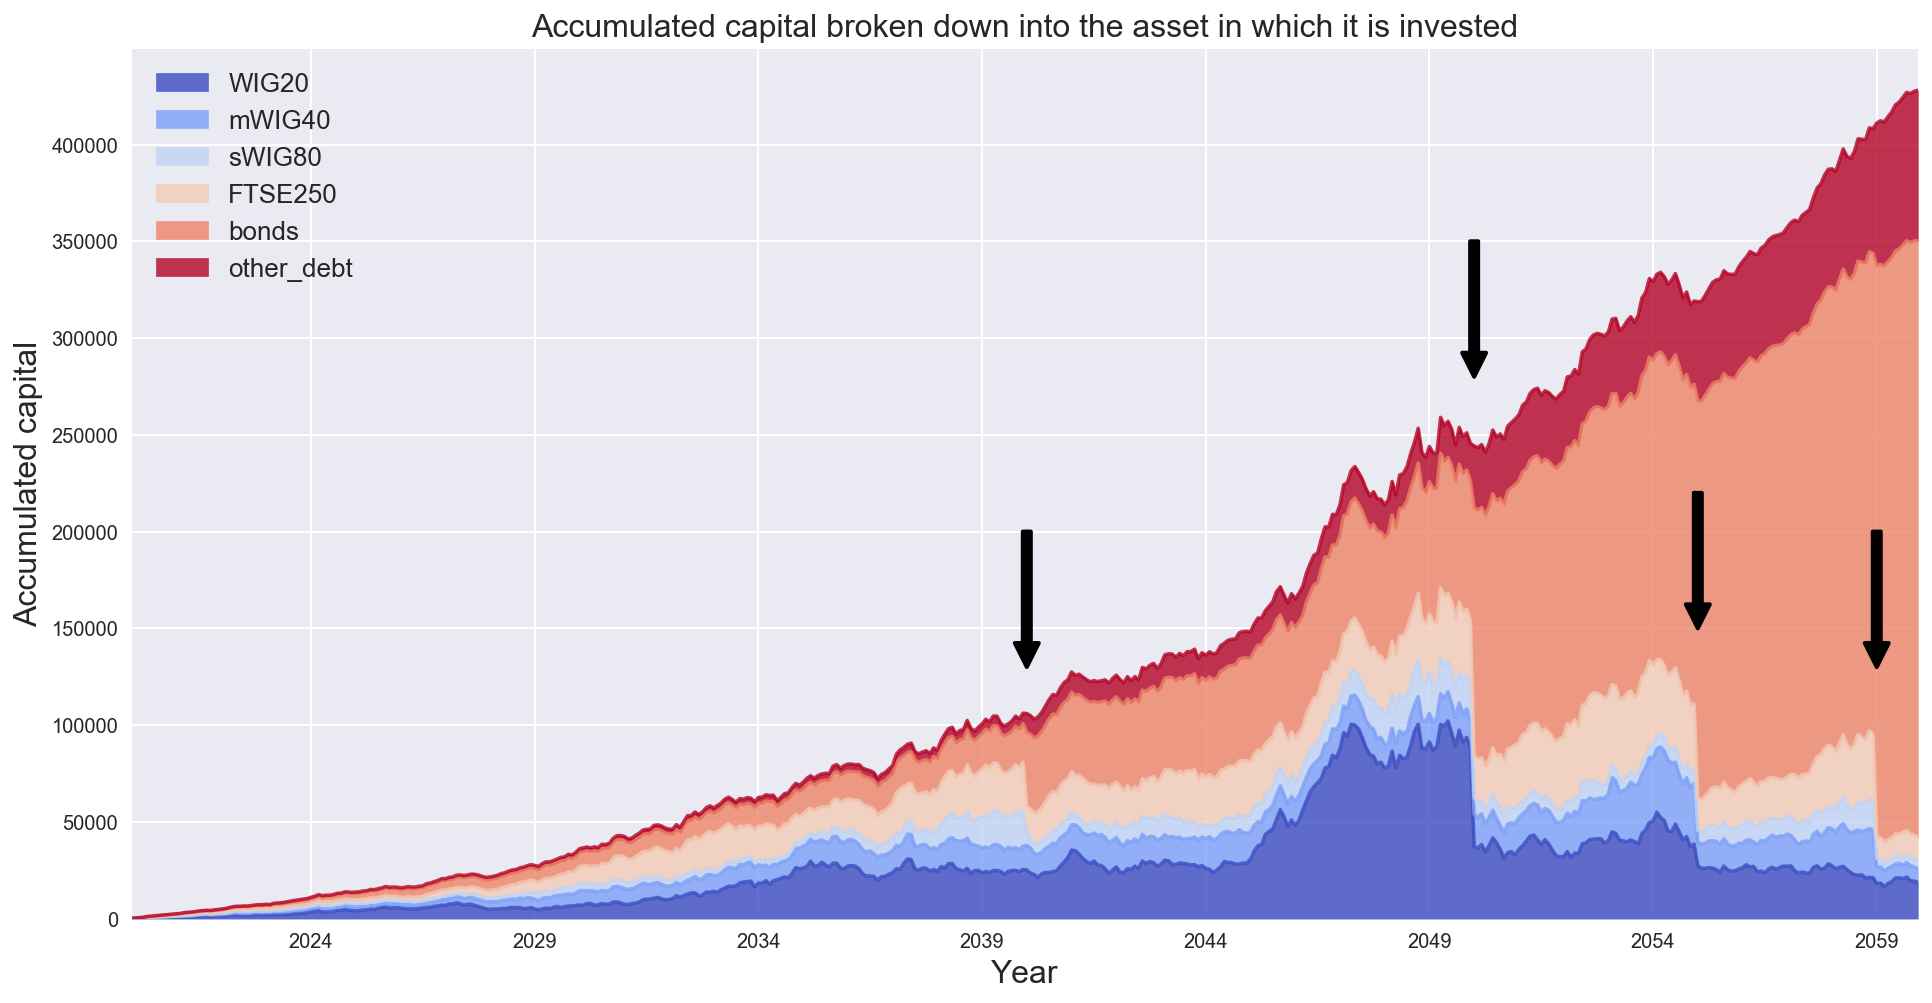

In [19]:
inv.plot(kind='area', figsize=(16,8), colormap='coolwarm', alpha=.8)
plt.title('Accumulated capital broken down into \
the asset in which it is invested'.format(column_name), fontdict={'fontsize':16})
plt.ylabel('Accumulated capital', fontdict={'fontsize':16})
plt.xlabel('Year', fontdict={'fontsize':16})
plt.legend(loc='best', prop={'size':13})

plt.annotate(s='', xytext=('2040-01-01', 200000), xy=('2040-01-01', 130000),
             arrowprops={'lw': 2, 'color': 'black'})
plt.annotate(s='', xytext=('2050-01-01', 350000), xy=('2050-01-01', 280000),
             arrowprops={'lw': 2, 'color': 'black'})
plt.annotate(s='', xytext=('2055-01-01', 220000), xy=('2055-01-01', 150000),
             arrowprops={'lw': 2, 'color': 'black'})
plt.annotate(s='', xytext=('2059-01-01', 200000), xy=('2059-01-01', 130000),
             arrowprops={'lw': 2, 'color': 'black'})

plt.show()

The chart above shows the development of the capital raised throughout the entire period of participation in PPK, broken down into the securities in which it was invested.

The vertical declines of capital invested in equities (marked on the chart with black arrows) indicate the months in which the obligatory transfer of the collected money took place to a more secure funds, which invest more in debt-based instruments. Thus, it can be seen how, along with approaching the day of retirement, capital is invested in safer financial instruments.

In addition, it can be seen that despite the fact that the companies included in the WIG20 index have a low rate of return, due to the fact that the largest part of the capital is obligatorily transferred to them, for about half the period they accounted for almost half of the accumulated capital.

In [20]:
total = inv.iloc[-1].sum()
first_payment = total / 120 
replacement_rate = first_payment / contributions['salary'].iloc[-1]
print('Replacement rate: {:.2%}'.format(replacement_rate))

Replacement rate: 15.93%


The replacement rate is the relation of the first retirement benefit (in this case, the first payment of funds raised under PPK) to the amount of the last salary. In the above case (assuming 40 years of saving on the minimum contribution rates and with generated rates of return), it is 15.93%.

In the next step, the payout phase will be simulated - the goal of saving in PPK is to receive payments after the end of activity in the labour market. The PPK Act suggests payment of 25% of the accumulated capital once at the beginning and the rest 75% of the capital in the form of monthly payments. However, this is not obligatory, so for the purposes of simulation I assume that the participant has not decided on this solution and the whole amount will be paid in instalments. The payout phase must last at least 10 years (120 months) and the remaining capital is invested mainly in debt instruments.

In [21]:
np.random.seed(20)
bonds_rate = (1+0.028)**(1/12)-1
other_debt_rate = (1+0.035)**(1/12)-1

value = total #starting with value equals to total accumulated capital
time = 120 # 120 months - 10 years

payout = pd.DataFrame(columns=['total_return', 'remaining_time', 'monthly_pension', 'remaining_value'],
    index=pd.date_range(start='2060-01-01', freq='MS', periods=time))

for index, row in payout.iterrows():
    
    payout.loc[index, 'total_return'] = (
    np.random.normal(org_returns['WIG20'].mean(), org_returns['WIG20'].std()) * 0.45 + 
    np.random.normal(org_returns['mWIG40'].mean(), org_returns['mWIG40'].std()) * 0.2 + 
    np.random.normal(org_returns['sWIG80'].mean(), org_returns['sWIG80'].std()) * 0.1 + 
    np.random.normal(org_returns['FTSE250'].mean(), org_returns['FTSE250'].std()) * 0.25) * 0.1 + (
    bonds_rate * 0.8 + 
    other_debt_rate * 0.2) * 0.9 + 1
    
    payout['remaining_time'].loc[index] = time    
    time = time - 1
    
    value = value * payout['total_return'].loc[index]
    value -= value * management_cost
    payout['monthly_pension'].loc[index] = value / row['remaining_time']
    
    value = value - row['monthly_pension']
    payout['remaining_value'].loc[index] = value
    
payout.head()

,total_return,remaining_time,monthly_pension,remaining_value
2060-01-01,1.00305,120,3576.43692,425595.99300
2060-02-01,0.99966,119,3573.74006,421701.32728
2060-03-01,1.00430,118,3587.60576,419749.87379
2060-04-01,0.99874,117,3581.60723,415466.43831
2060-05-01,1.00561,116,3600.21120,414024.28778


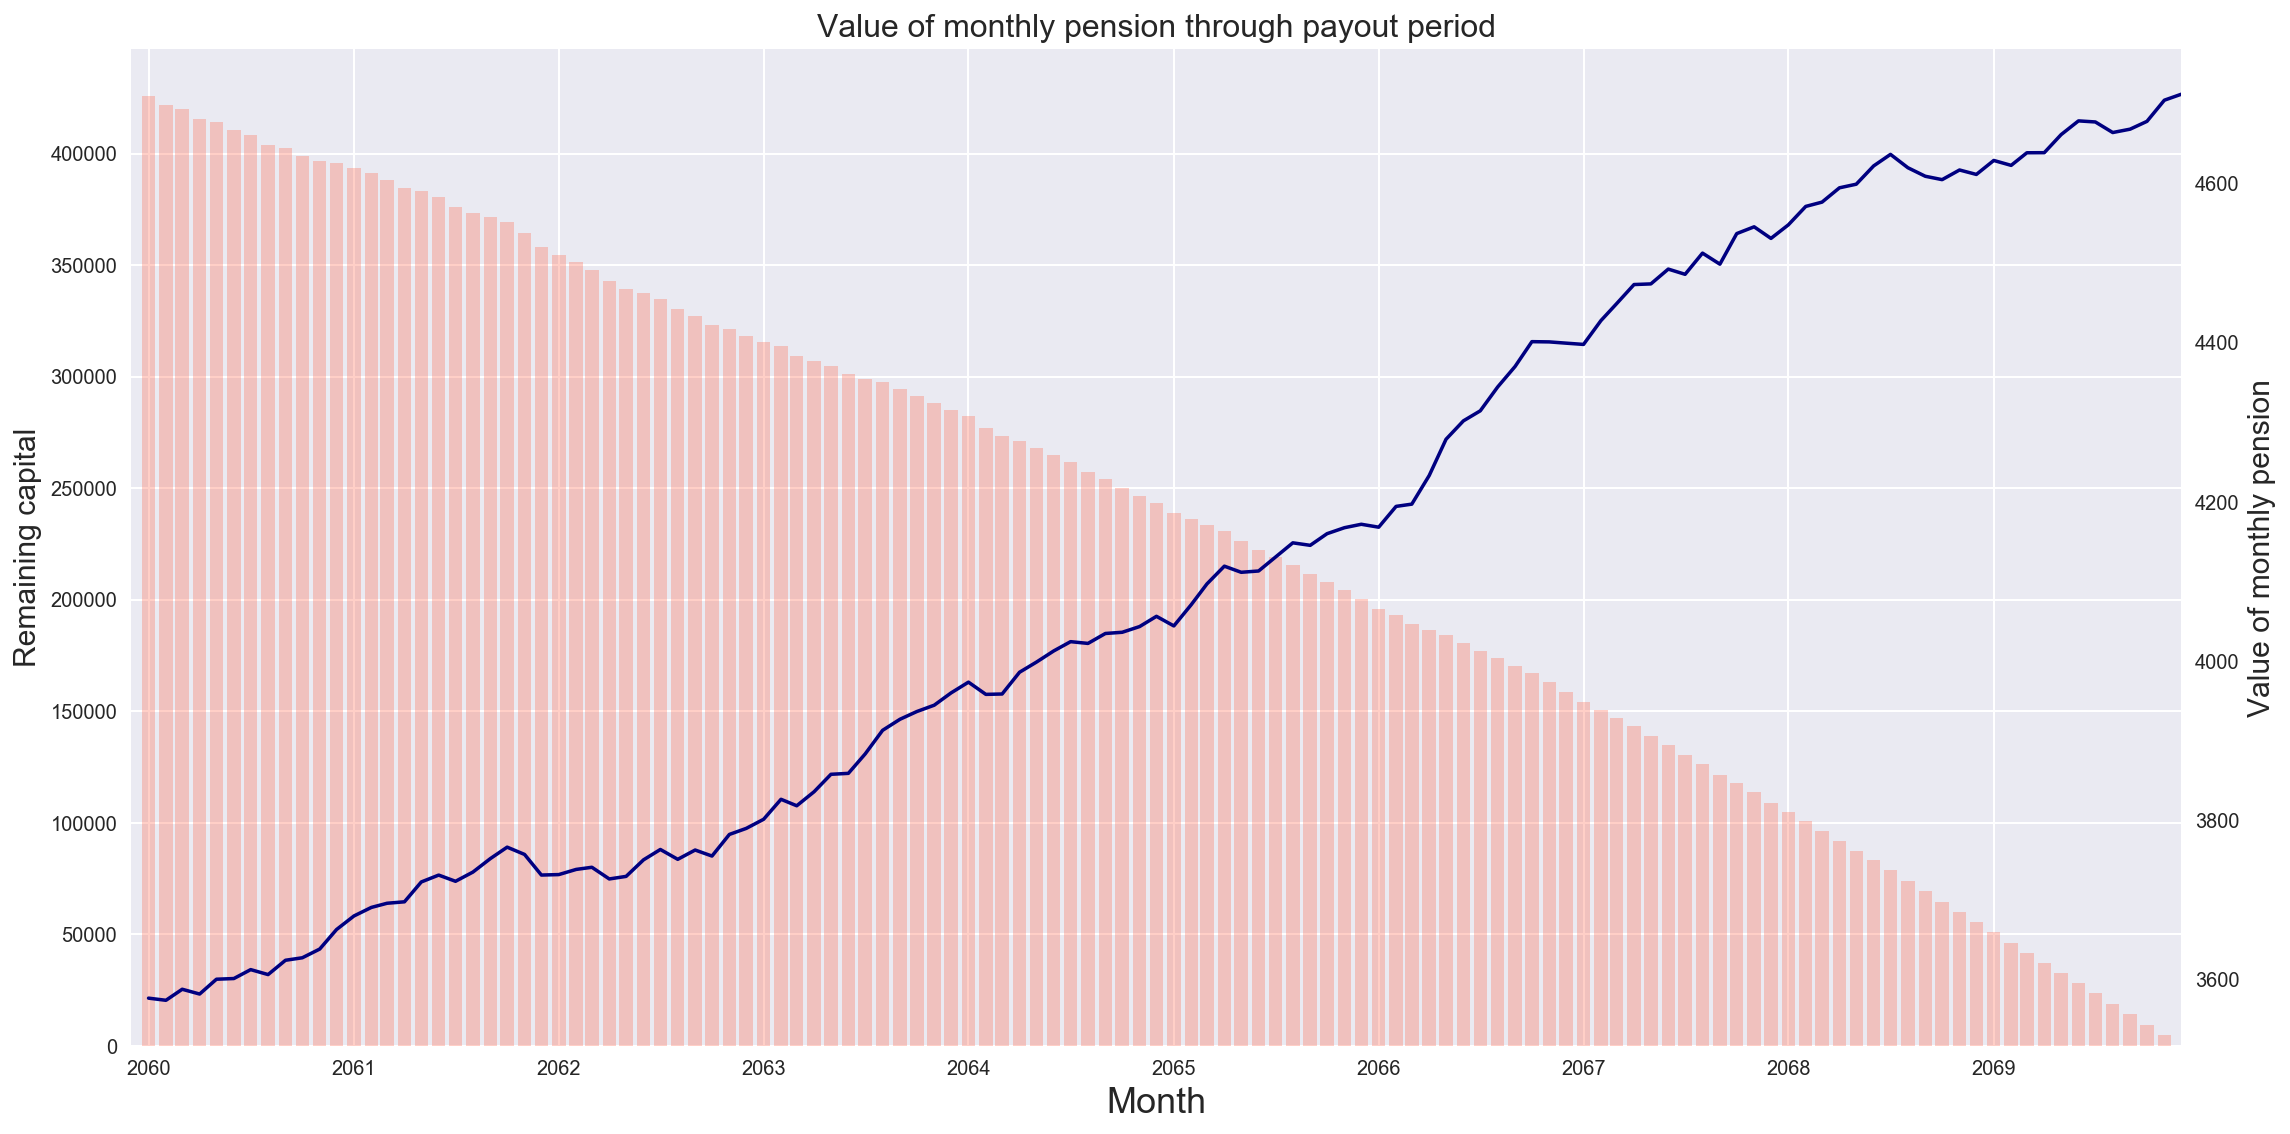

In [22]:
fig, ax1 = plt.subplots(figsize=(16,8))
ax2 = ax1.twinx()
ax1.bar(payout.index, payout['remaining_value'], color='tomato', width=24, alpha=0.3)
ax2.plot(payout['monthly_pension'], color='navy')
ax2.grid()
ax1.set_title('Value of monthly pension through payout period', fontdict={'fontsize':16})
ax1.set_xlabel('Month', fontdict={'fontsize':18})
ax1.set_ylabel('Remaining capital', fontdict={'fontsize':15})
ax2.set_ylabel('Value of monthly pension', fontdict={'fontsize':15}) 
ax1.set_xlim(contributions.index.max(), payout.index.max())
plt.tight_layout()
plt.show()

The chart above shows two things: the consumption of accumulated capital and the value of the monthly payment. Bearing in mind that the accumulated capital during the payout phase is constantly invested,  the monthly amount fluctuates - in the first month it was 3.5k PLN, and after 10 years more than a thousand more. However, the pensioner may not feel this slight increase - its effect will probably be minimized by inflation.

A random element plays an important role in the model, i.e. by generating a rate of return, so replacement rate varies a lot. In the next step return rates will be calculated 100 times (with the same assumptions of 40 years and minimum contributions) to check how much the replacement rate can be shaped depending solely on returns.

In [23]:
#creating new empty dataframe for results
volatility = pd.DataFrame(columns=['replacement_rate'])

contributions = get_contributions(40, 0.035)
share = get_shares(40)

for i in range(1, 101):    

    returns = get_returns(40)
    costs = get_costs(40)
    inv = get_inv(40)

    total = inv.iloc[-1].sum()
    first_payment = total / 120
    score = first_payment / contributions['salary'].iloc[-1]

    volatility.loc['Attemp no. {}'.format(i), 'replacement_rate'] = score

In [24]:
print('Mean replacement rate: {:.2%}'.format(volatility['replacement_rate'].mean()))
print('Standard deviation: {:.2%}'.format(volatility['replacement_rate'].std()))

Mean replacement rate: 17.29%
Standard deviation: 4.12%


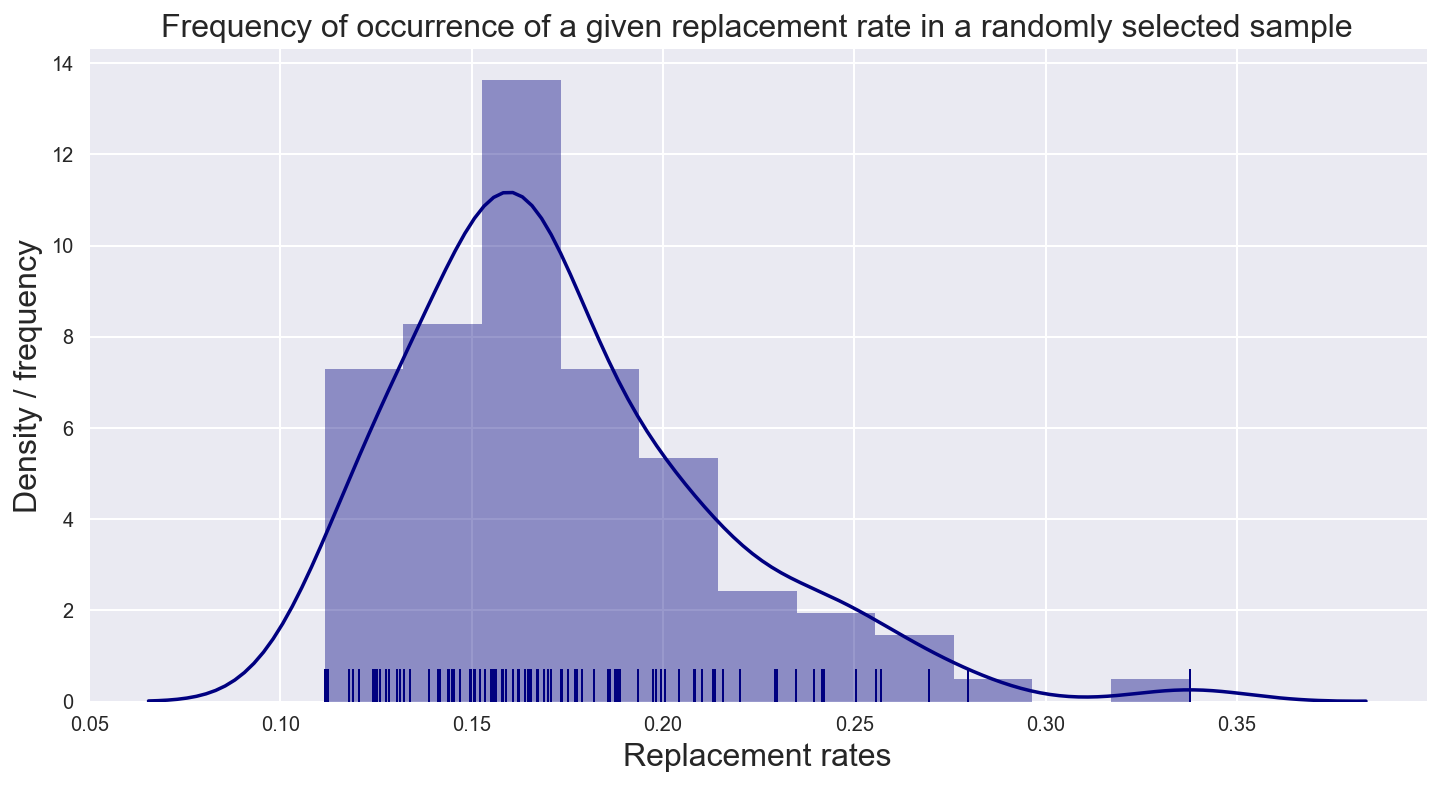

In [25]:
plt.figure(figsize=(12,6))
sns.distplot(volatility['replacement_rate'], color='navy', rug=True)
plt.title('Frequency of occurrence of a given replacement rate in a randomly selected sample', 
          fontdict={'fontsize':16})
plt.ylabel('Density / frequency', fontdict={'fontsize':16})
plt.xlabel('Replacement rates', fontdict={'fontsize':16})
plt.show()

As presented in the chart above, generating rates of return have a huge great impact on the final replacement rate. Although the rates in each of the hundred cases were generated on the basis of the same original, historical data from 2000-2020, the replacement rate ranges from 11% to as much as 33%. The standard deviation in this case is significant. Despite this, in most cases the replacement rate was around 17%.

The next, main step of the analysis is to check how much the replacement rate changes with the simultaneous change of the length of participation and contribution rates. Considering that the replacement rate may vary considerably depending on the generated returns (see above), the replacement rate should be calculated as many times as possible. Then, the average rate would be applied to the table score. Unfortunately, due to the limited computing power, in each case the replacement rate will be calculated only five times - after all, to some extent, it will protect against generating extreme, unlikely results.

In [26]:
replacement_matrix = pd.DataFrame()
years = np.arange(5, 41)
contribution_rates = np.arange(0.035, 0.085, 0.005)

for year in years:
    share = get_shares(year)
    for rate in contribution_rates:
        volatility = pd.DataFrame(columns=['replacement_rate'])
        for i in range(1, 6):

            contributions = get_contributions(year, rate)
            returns = get_returns(year)
            costs = get_costs(year)
            inv = get_inv(year)

            total = inv.iloc[-1].sum()
            first_payment = total / 120
            score = first_payment / contributions['salary'].iloc[-1]

            volatility.loc[i, 'replacement_rate'] = score

        replacement_matrix.loc[year, rate] = volatility.mean()[0]

In [27]:
replacement_matrix.columns = ['3.5%', '4.0%', '4.5%', '5.0%', '5.5%', 
                              '6.0%', '6.5%', '7.0%', '7.5%', '8.0%']

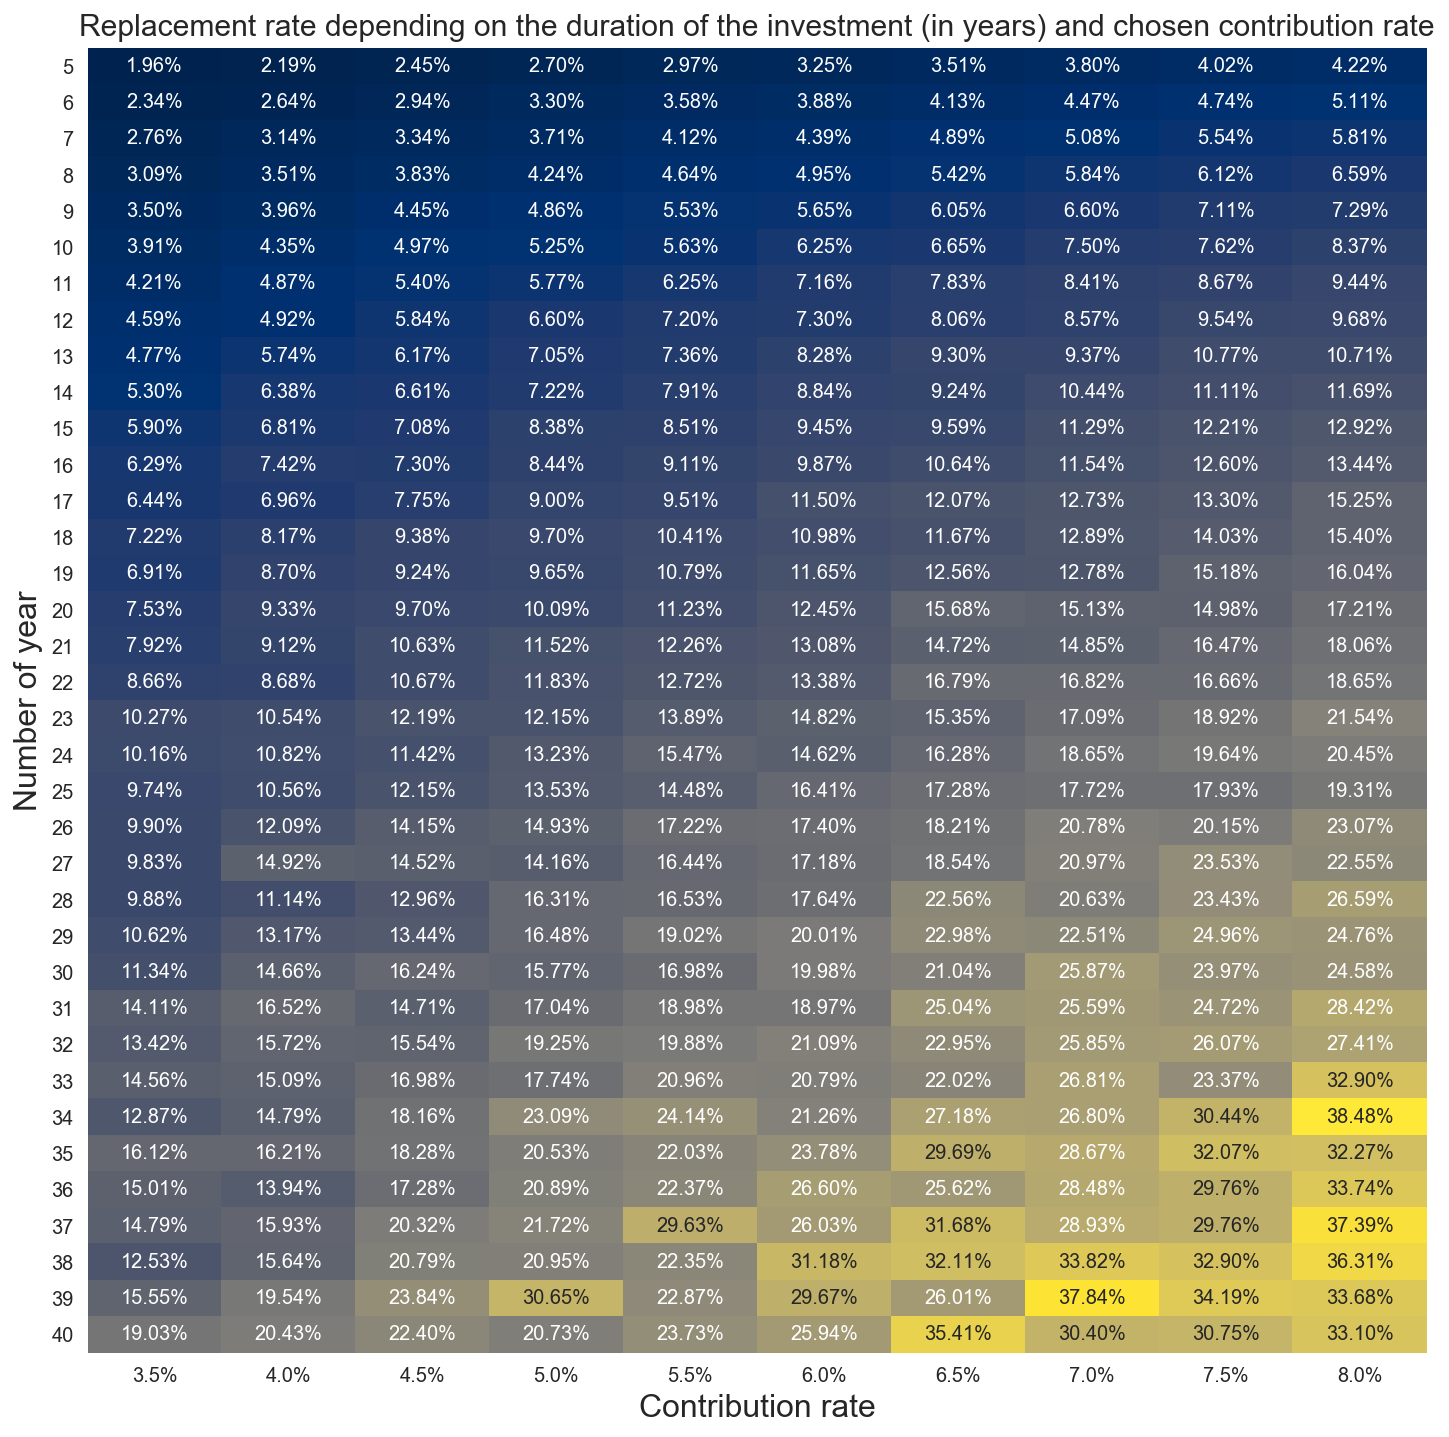

In [28]:
plt.figure(figsize=(12,12))
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.top'] = True
sns.heatmap(replacement_matrix, annot=True,  cmap="cividis", cbar=False, fmt='0.2%', annot_kws={'size':10})
plt.yticks(rotation=0)
plt.title('Replacement rate depending on the duration of the investment \
(in years) and chosen contribution rate'.format(column_name), fontdict={'fontsize':15})
plt.ylabel('Number of year', fontdict={'fontsize':16})
plt.xlabel('Contribution rate', fontdict={'fontsize':16})
plt.show()

It is obvious that the longer the participant saves during all these years and the more he contributes to his account every month, the higher the benefit from PPK will be. However, what is visible only after calculating many possible options is that the benefits paid will be simply... low. The European Commission report predicts that in 2060 the replacement rate for Poland will be only 28.7% (compared to 53% in 2013) - "The 2015 ageing report: Economic and budgetary projections for the 28 EU member states (2013–2060)", European Economy 2015, no 3, page 93.

However, it is important to point out that the optimal, **target replacement rate** to maintain the current level of life before retirement is, according to various estimates, from 60% to 80%. Considering the above, the replacement rate guaranteed by PPK should be at least 30%.
 


In [29]:
replacement_matrix[replacement_matrix >= 0.25].dropna(how='all').fillna('-')

,3.5%,4.0%,4.5%,5.0%,5.5%,6.0%,6.5%,7.0%,7.5%,8.0%
28,-,-,-,-,-,-,-,-,-,0.26587
30,-,-,-,-,-,-,-,0.25866,-,-
31,-,-,-,-,-,-,0.25036,0.25589,-,0.28421
32,-,-,-,-,-,-,-,0.25851,0.26072,0.27408
33,-,-,-,-,-,-,-,0.26814,-,0.32901
34,-,-,-,-,-,-,0.27180,0.26805,0.30443,0.38477
35,-,-,-,-,-,-,0.29693,0.28672,0.32075,0.32275
36,-,-,-,-,-,0.26600,0.25619,0.28485,0.29765,0.33736
37,-,-,-,-,0.29631,0.26028,0.31677,0.28931,0.29763,0.37395
38,-,-,-,-,-,0.31177,0.32110,0.33823,0.32895,0.36308


However, even by lowering the requirement to only 25%, this replacement rate can only be achieved if you save for at least 30 years. What's more, the monthly contribution in this case should oscillate among the upper limits, which is highly unlikely for most of people.

The analysis indicates that the introduced PPK program is not perfect. On the one hand, the state's efforts to ensure future pensions of Poles should be appreciated. Additional activity consisting in saving extra for retirement purposes is necessary. From the perspective of the individual, it is important that future benefits will be supplemented by the employer and, to a small extent, by the state. 

On the other hand, however, projected low replacement rates cannot be ignored. Although, it is not possible to create a retirement system that everyone, including State, would love, it is good that PPK system was create. Even imperfect will make future pensions at least slightly higher. However, an accurate and reliable assessment of the new system will be possible only after a few or even several years of its functioning.

# Thank you very much! :)